In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Lecture 16 – Hypothesis Testing

## DSC 10, Fall 2022

### Announcements

- Midterm Exam scores are available. See [this post](https://edstem.org/us/courses/29053/discussion/2057383) for details.
    - Only worth 10%. Take it as a learning experience!
- The Midterm Project is due **tomorrow at 11:59pm**.
    - Slip days can be used if needed.
    - If working with a partner, only **one** person should submit and "Add Group Member" on Gradescope.
    - TA and tutors will host group office hours in the **SDSC Auditorium, tomorrow from 7-9pm**. Come to work and/or get help.
- Lab 5 is due **Saturday 11/5 at 11:59pm**.

### Agenda

- Decisions and uncertainty.
- Example: Midterm scores.
    - p-values.
- Example: Jury selection in Alameda County.
    - Total variation distance.

## Decisions and uncertainty

### Incomplete information

- We try to choose between two views of the world, based on data in a sample.
     - Example: "this coin is fair" or "this coin is unfair."

- It's not always clear whether the data are consistent with one view or the other.

- Random samples can turn out quite extreme. It is unlikely, but possible.

### Testing hypotheses
- A test chooses between two views of how data were generated.

- The views are called **hypotheses**.

- The test picks the hypothesis that is *better* supported by the observed data.
    - It doesn't guarantee that either hypothesis is correct.

### Null and alternative hypotheses

- Our method of hypothesis testing only works if we can simulate data under one of the hypotheses.

- **Null hypothesis**: A well-defined probability model about how the data was generated.
    - We need to be able to simulate data under the assumptions of this model, i.e. "under the null hypothesis."

- **Alternative hypothesis**: A different view about the origin of the data.

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

Consider the pair of hypotheses "this coin is fair" and "this coin is unfair."

Which is the null hypothesis?

- A) "This coin is fair."
- B) "This coin is unfair."
- C) Either could be the null hypothesis; it doesn't matter which one we pick.

### Test statistics, revisited
- Recall, we compute the test statistic on each of the samples in our simulation.

- Its goal is to give us information that will help us in determining which hypothesis to side with.

- The test statistic evaluated on our observed data is called the **observed statistic**.

### Considerations when choosing a test statistic

- Our test statistic should be such that either:
    - High values lean towards one viewpoint and low values lean towards the other.
    - Low values lean towards one viewpoint and high values lean towards other.

- We will avoid test statistics where both high and low values lean towards one viewpoint and values in the middle lean towards the other.
    - In other words, we will avoid "two-sided" tests.    

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

Consider the pair of hypotheses "this coin is fair" and "this coin is unfair." Which test statistic(s) could we use to test these hypotheses?

- A) Number of heads in 400 flips.
- B) Absolute difference between proportion of heads and proportion of tails in 400 flips. 
- C) Proportion of tails in 400 flips minus 0.5.
- D) More than one of the above.

### Empirical distribution of the test statistic
- When performing a hypothesis test, we **simulate** the test statistic **under the null hypothesis** and draw a histogram of the simulated values.

- This shows us the **empirical distribution of the test statistic under the null hypothesis**.
    - It shows all of the likely values of the test statistic.
    - It also shows how likely they are, under the assumption that the null hypothesis is true.
    - The probabilities are approximate, because we can’t generate all possible random samples.

- Remember, we plan to use the value observed statistic to help us choose between the hypotheses. 
    - "High" sways us one way, "low" the other. 
- The purpose of the empirical distribution is to clarify where the boundary between "high" and "low" actually falls.
- We side with the null only if the observed statistic is **consistent** with the empirical distribution of the test statistic.

**Question for today:** Is there a formal definition for what we mean by "consistent"?

### Example: Is my coin fair?

In [2]:
fair_coin = [0.5, 0.5]

repetitions = 10000
test_stats = np.array([])
for i in np.arange(repetitions):
    coins = np.random.multinomial(400, fair_coin)
    test_stat = abs(coins[0]/400 - coins[1]/400)
    test_stats = np.append(test_stats, test_stat)

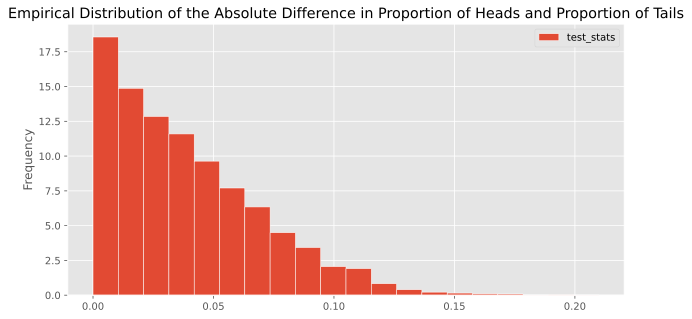

In [3]:
bpd.DataFrame().assign(test_stats = test_stats).plot(kind='hist', bins=20,
                                             density=True, ec='w', figsize=(10, 5),
                                             title='Empirical Distribution of the Absolute Difference in Proportion of Heads and Proportion of Tails');
plt.legend();

Small values of the observed statistic should make you side with the null hypothesis, that the coin is fair. But **how small**?

## Example: Midterm exam scores

### The problem

- This quarter, there are four sections of DSC 10 – A, B, C, and D.

- Each student is in exactly one section.

- One of the four sections had a much lower average than the other three sections.
    - All midterms were graded by the same people, with the same rubrics.

In [4]:
# Midterm scores from DSC 10, Fall 2022, slightly perturbed for anonymity.
scores = bpd.read_csv('data/fa22-midterm-scores.csv')
scores

,Section,Score
0,A,54.5
1,D,62.0
2,B,23.5
...,...,...
390,C,62.5
391,B,47.5
392,D,72.5


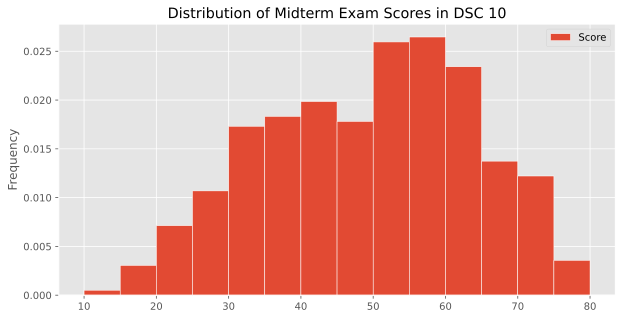

In [5]:
scores.plot(kind='hist', density=True, figsize=(10, 5), ec='w', bins=np.arange(10, 85, 5), title='Distribution of Midterm Exam Scores in DSC 10');

In [6]:
# Total number of students who took the exam.
scores.shape[0]

393

In [7]:
# Calculate the number of students in each section.
scores.groupby('Section').count()

,Score
Section,
A,117
B,115
C,108
D,53


In [8]:
# Calculate the average midterm score in each section.
scores.groupby('Section').mean()

,Score
Section,
A,51.54
B,49.48
C,46.17
D,50.88


<details>
    <summary>😱</summary>
    <center><img src="data/surprise.png" width=25%></center>
</details>

### Thought experiment 💭🧪

- Suppose we _randomly_ place all 393 students into one of four sections and computed the average midterm score within each section. 

- One of the sections would _have to_ have a lower average score than the others (unless multiple are tied for the lowest).
    - In any set of four numbers, one of them has to be the minimum!

- But is Section C's average _lower_ than we'd expect due to chance? Let's perform a hypothesis test!

### Suraj's defense

- **Null Hypothesis**: Section C's scores are drawn randomly from the distribution of scores in the course overall. The observed difference between the average score in Section C and the average score in the course overall is due to random chance.

- **Alternative Hypothesis**: Section C's average score is too low to be explained by chance alone.




### What are the observed characteristics of Section C?

In [9]:
section_size = scores.groupby('Section').count().get('Score').loc['C']
observed_avg = scores.groupby('Section').mean().get('Score').loc['C']
print(f'Section C had {section_size} students and an average midterm score of {observed_avg}.')

Section C had 108 students and an average midterm score of 46.1712962962963.


### Simulating under the null hypothesis
- Model: There is no significant difference between the exam scores in different sections. Section C had a lower average purely due to chance.
    - To simulate: sample 108 students uniformly at random without replacement from the class. 

- Test statistic: the average midterm score of a section.
    - The observed statistic is the average midterm score of Section C (about 46.17).

In [10]:
# Samples 108 students from the class, independent of section, 
# and computes the average score.
scores.sample(int(section_size), replace=False).get('Score').mean()

47.01851851851852

In [11]:
averages = np.array([])
repetitions = 1000
for i in np.arange(repetitions):
    random_sample = scores.sample(int(section_size), replace=False)
    new_average = random_sample.get('Score').mean()
    averages = np.append(averages, new_average)
    
averages

array([49.22, 49.28, 49.41, ..., 48.72, 51.19, 49.1 ])

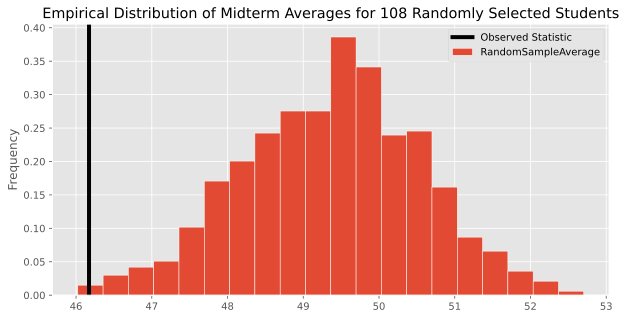

In [12]:
bpd.DataFrame().assign(RandomSampleAverage=averages).plot(kind='hist', bins=20, 
                                                          density=True, ec='w', figsize=(10, 5), 
                                                          title='Empirical Distribution of Midterm Averages for 108 Randomly Selected Students')
plt.axvline(observed_avg, color='black', linewidth=4, label='Observed Statistic')
plt.legend();

### What's the verdict? 🤔
- Section C's lower performance _could_ be due to random chance, but it doesn't seem too likely. 

- Can we say how likely?

## Statistical significance

**Question:** What is the probability that under the null hypothesis, a result *at least* as extreme as our observation occurs?

- In this example, what is the probability that under the null hypothesis, a randomly selected group of 108 students has an average exam score of 46.17 or lower?

- This quantity is called a **p-value**.

- This represents the **area in the tail of the empirical distribution**.

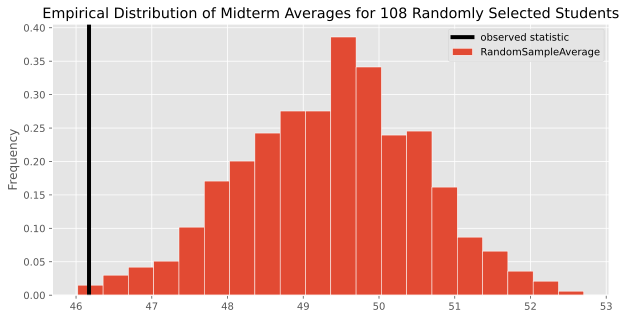

In [13]:
bpd.DataFrame().assign(RandomSampleAverage=averages).plot(kind='hist', bins=20, 
                                                          density=True, ec='w', figsize=(10, 5), 
                                                          title='Empirical Distribution of Midterm Averages for 108 Randomly Selected Students')
plt.axvline(observed_avg, color='black', linewidth=4, label='observed statistic')
plt.legend();

In [14]:
observed_avg

46.1712962962963

In [15]:
np.count_nonzero(averages <= observed_avg) / repetitions

0.004

### Definition of the p-value

- The p-value is the probability, under the null hypothesis, that the test statistic is equal to the value that was observed in the data or is even further **in the direction of the alternative**.

- Its formal name is the _observed significance level_.

- In the previous visualization, it is the area to the left of the black line (i.e. the area in the left tail, starting at the observed statistic).
   - But sometimes the p-value corresponds to the area in the right tail; it depends on whether larger or smaller values correspond to the alternative hypothesis.

### Conventions about inconsistency

- If the p-value is sufficiently large, we say the data is **consistent** with the null hypothesis and so we "**fail to reject the null hypothesis**".
    - We never say that we "accept" the null hypothesis!
    - Why not? We found that the null hypothesis is plausible, but there are many other possible explanations for our data.

- If the p-value is below some cutoff, we say it is **inconsistent** with the null hypothesis, and we **"reject the null hypothesis"**.
    - p-values correspond to the "tail areas" of a histogram, starting at the observed statistic.
    - If a p-value is less than 0.05, the result is said to be "statistically significant".
    - If a p-value is less than 0.01, the result is said to be "highly statistically significant".
    - These conventions are historical and completely arbitrary! (And controversial.)

### What does the p-value mean?

The cutoff for the p-value is an error probability. If:

- your cutoff is 0.05, and
- the null hypothesis happens to be true

then there is about a 0.05 chance that your test will (incorrectly) reject the null hypothesis.

In other words, if Suraj teaches 20 sections of DSC 10, he would expect to see students with a "statistically significantly low" average in one of those sections. 

## Comparing distributions

### Jury selection in Alameda County

<br>

<center><img src='data/aclu.png' width=500></center>

### Jury panels

Recall from Lecture 15:

<center>$\substack{\text{eligible} \\ \text{population}}
\xrightarrow{\substack{\text{representative} \\ \text{sample}}} 
\substack{\text{jury} \\ \text{panel}}
\xrightarrow{\substack{\text{selection by} \\ \text{judge/attorneys}}} 
\substack{\text{actual} \\ \text{jury}}$</center>

Section 197 of California's Code of Civil Procedure says, 
> "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

### ACLU study
- The ACLU (American Civil Liberties Union) of Northern California [studied](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) the ethnic composition of jury panels in 11 felony trials in Alameda County between 2009 and 2010.

- 1453 people reported for jury duty in total (we will call them "panelists").

- The following DataFrame shows the distribution in ethnicities for both the eligible population and for the panelists who were studied.

In [16]:
jury = bpd.DataFrame().assign(
    Ethnicity=['Asian', 'Black', 'Latino', 'White', 'Other'],
    Eligible=[0.15, 0.18, 0.12, 0.54, 0.01],
    Panels=[0.26, 0.08, 0.08, 0.54, 0.04]
)
jury

,Ethnicity,Eligible,Panels
0,Asian,0.15,0.26
1,Black,0.18,0.08
2,Latino,0.12,0.08
3,White,0.54,0.54
4,Other,0.01,0.04


What do you notice? 👀

### Are the differences in representation meaningful?
- **Null Hypothesis:** Panelists were selected at random from the eligible population.

- **Alternative Hypothesis:** Panelists were _not_ selected at random from the eligible population.

- Observation: 1453 panelists and the distribution of their ethnicities.

- Test statistic: ???
    - How do we deal with multiple categories?

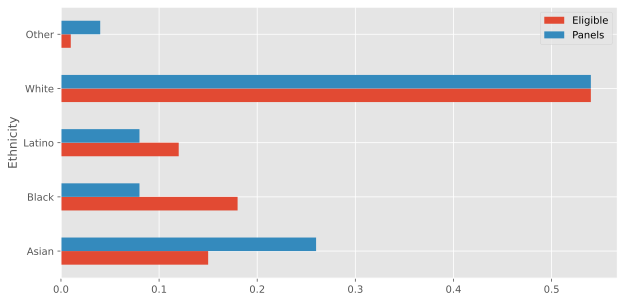

In [17]:
jury.plot(kind='barh', x='Ethnicity', figsize=(10, 5));

### The distance between two distributions
- Panelists are categorized into one of 5 ethnicities. In other words, ethnicity is a **categorical** variable.

- To see whether the the distribution of ethnicities for the panelists is similar to that of the eligible population, we have to measure the distance between two categorical distributions.
    - We've done this for distributions with just two categories – heads and tails, for instance – but not when there are more than two categories.

### The distance between two distributions
- Let's start by considering the difference in proportions for each category.

In [18]:
with_diffs = jury.assign(Difference=(jury.get('Panels') - jury.get('Eligible')))
with_diffs

,Ethnicity,Eligible,Panels,Difference
0,Asian,0.15,0.26,0.11
1,Black,0.18,0.08,-0.10
2,Latino,0.12,0.08,-0.04
3,White,0.54,0.54,0.00
4,Other,0.01,0.04,0.03


- Note that if we sum these differences, the result is 0 (you'll see the proof in DSC 40A).
- To avoid cancellation of positive and negative differences, we can take the absolute value of these differences.

In [19]:
with_abs_diffs = with_diffs.assign(AbsoluteDifference=np.abs(with_diffs.get('Difference')))
with_abs_diffs

,Ethnicity,Eligible,Panels,Difference,AbsoluteDifference
0,Asian,0.15,0.26,0.11,0.11
1,Black,0.18,0.08,-0.10,0.10
2,Latino,0.12,0.08,-0.04,0.04
3,White,0.54,0.54,0.00,0.00
4,Other,0.01,0.04,0.03,0.03


### Statistic: Total Variation Distance

The **Total Variation Distance (TVD)** of two categorical distributions is **the sum of the absolute differences of their proportions, all divided by 2**.

- We divide by 2 so that, for example, the distribution [0.51, 0.49] is 0.01 away from [0.50, 0.50].

- This way, TVD quantifies the **total overrepresentation** across all categories.

- It would also be valid not to divide by 2. We just wouldn't call that statistic TVD anymore.

In [20]:
with_abs_diffs

,Ethnicity,Eligible,Panels,Difference,AbsoluteDifference
0,Asian,0.15,0.26,0.11,0.11
1,Black,0.18,0.08,-0.10,0.10
2,Latino,0.12,0.08,-0.04,0.04
3,White,0.54,0.54,0.00,0.00
4,Other,0.01,0.04,0.03,0.03


In [21]:
with_abs_diffs.get('AbsoluteDifference').sum() / 2

0.14

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

What is the TVD between the distributions of class standing in DSC 10 and DSC 40A?

| **Class Standing** | **DSC 10** | **DSC 40A** |
| --- | --- | --- |
| Freshman | 0.45 | 0.15 |
| Sophomore | 0.35 | 0.35 |
| Junior | 0.15 | 0.35 |
| Senior+ | 0.05 | 0.15 |

- A. 0.2
- B. 0.3
- C. 0.5
- D. 0.6
- E. None of the above

### Statistic: Total Variation Distance

In [22]:
def total_variation_distance(dist1, dist2):
    '''Computes the TVD between two categorical distributions, 
       assuming the categories appear in the same order.'''
    return np.abs((dist1 - dist2)).sum() / 2

In [23]:
# Calculate the TVD between the distribution of ethnicities in the eligible population
# and the distribution of ethnicities in the observed panelists.

total_variation_distance(jury.get('Eligible'), jury.get('Panels'))

0.14

- The closer the TVD is to 0, the closer the two distributions are to one another.
- But is 0.14 a very small value? A typical value? A very large value?

### Simulate drawing jury panels
- Model: Panels are drawn at from the eligible population.

- Statistic: TVD between the random panel's ethnicity distribution and the eligible population's ethnicity distribution.

- Repeat many times to generate many TVDs, and see where the TVD of the observed panelists lies.

_Note_: `np.random.multinomial` creates samples drawn with replacement, even though real jury panels would be drawn without replacement. However, when the sample size (1453) is small relative to the population (number of people in Alameda County), the resulting distributions will be roughly the same whether we sample with or without replacement.

### The simulation

In [24]:
eligible = jury.get('Eligible')
sample_distribution = np.random.multinomial(1453, eligible) / 1453 
sample_distribution

array([0.15, 0.17, 0.13, 0.54, 0.01])

In [25]:
total_variation_distance(sample_distribution, eligible)

0.015939435650378524

### Repeating the experiment

In [26]:
tvds = np.array([])
repetitions = 10000
for i in np.arange(repetitions):
    sample_distribution = np.random.multinomial(1453, eligible) / 1453
    new_tvd = total_variation_distance(sample_distribution, eligible)
    tvds = np.append(tvds, new_tvd)

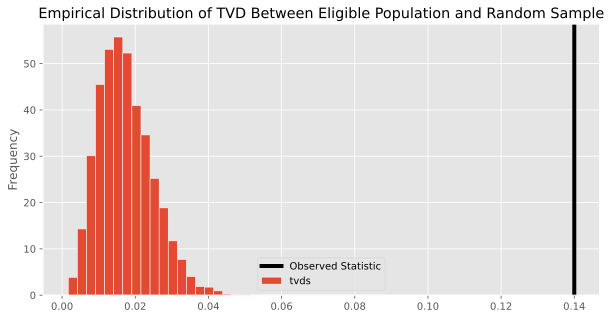

In [27]:
observed_tvd = total_variation_distance(jury.get('Panels'), eligible)

bpd.DataFrame().assign(tvds=tvds).plot(kind='hist', density=True, bins=20, ec='w', figsize=(10, 5),
                                      title='Empirical Distribution of TVD Between Eligible Population and Random Sample')
plt.axvline(observed_tvd, color='black', linewidth=4, label='Observed Statistic')
plt.legend();

### Calculating the p-value

In [28]:
np.count_nonzero(tvds >= observed_tvd) / repetitions

0.0

- Random samples from the eligible population are typically **much more similar** to the eligible population than our observed data. 
- We see this in the empirical distribution, which consists of **small TVDs** (much smaller than our observed TVD).

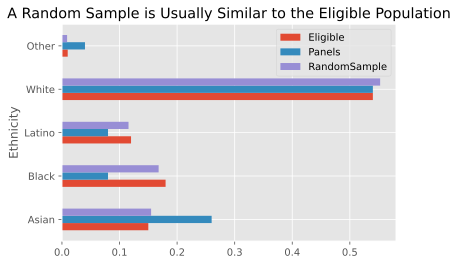

In [29]:
jury.assign(RandomSample=sample_distribution).plot(kind='barh', x='Ethnicity', 
                                                   title = "A Random Sample is Usually Similar to the Eligible Population");

### Are the jury panels representative?
- Likely not! The distributions of ethnicities in our random samples are not like the distribution of ethnicities in our observed panelists.

- This doesn't say *why* the distributions are different!
    - Juries are drawn from voter registration lists and DMV records. Certain populations are less likely to be registered to vote or have a driver's license due to historical biases.
    - The county rarely enacts penalties for those who don't appear for jury duty; certain populations are less likely to be able to miss work to appear for jury duty.
    - [See the report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) for more reasons.

## Summary, next time

### The hypothesis testing "recipe"

1. **State hypotheses**: State the null and alternative hypotheses. We must be able to simulate data under the null hypothesis.
1. **Choose test statistic**: Choose something that allows you to distinguish between the two hypotheses based on whether its value is high or low.
1. **Simulate**: Draw samples under the null hypothesis, and calculate the test statistic on each one.
1. **Visualize**: Plot the simulated values of the test statistic in a histogram, and compare this to the observed statistic (black line).
1. **Calculate p-value**: Find the proportion of simulations for which the test statistic was at least as extreme as the one observed.

### Why does it matter?

- Hypothesis testing is used all the time to make decisions in science and business.
- Hypothesis testing quantifies how "weird" a result is.
    - Instead of saying, "I think that's unusual," people say, "This has a p-value of 0.001."
- Through simulation, we have the tools to estimate how _likely_ something is, without needing to know a ton about probability theory.

### Next time

- All our hypothesis tests so far have involved sampling from a known distribution. 
- How do we test whether two samples are from the same **unknown** distribution?